In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

In [3]:
def convert_to_plt(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Extracting frames from Video

Here we are using `openCV` to extract frames from the video dataset

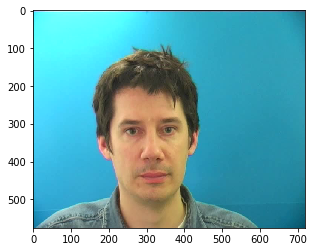

In [5]:
from playground import VideoObject, AlignObject

filename = "bbaf2n"

videoPath = "./data/videos/%s.mpg"%filename
alignPath = "./data/s1/align/%s.align"%filename

videoObj = VideoObject(videoPath)
alignObj = AlignObject(alignPath)

frame, pos = videoObj.get_frame_with_pos()

# frame_plt = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(convert_to_plt(frame))

# Getting Lip Region from Frame

### Here we have done the following tasks
- Apply haar cascade to extract lip area
- Resize the cropped region to (64, 64) image
- Convert it to gray scale
- Write the frame in its directory

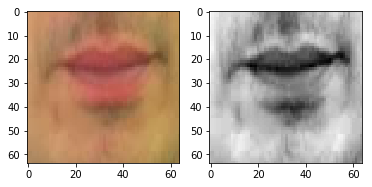

In [16]:
from frame_extractor import extract_lip

fig = plt.figure()

lip_frame = extract_lip(frame)


lip_gray = cv2.cvtColor(lip_frame, cv2.COLOR_BGR2GRAY)


fig.add_subplot(1, 2, 1)
plt.imshow(convert_to_plt(lip_frame))
# plt.axis('off')




# print(lip_gray.shape)

fig.add_subplot(1, 2, 2)
plt.imshow(lip_gray, cmap='gray')
# plt.axis('off')



# Words preprocessed

Here are the words which we have in our dataset

In [5]:
cleaned_path = './data/cleaned/'
words = os.listdir(cleaned_path)
# print(words)
print(np.array(words))

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'd' 'e' 'eight' 'f' 'five' 'four'
 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now' 'o' 'one'
 'please' 'q' 'r' 'red' 's' 'seven' 'sil' 'six' 'soon' 'sp' 't' 'three'
 'two' 'u' 'white' 'with' 'x' 'y' 'z' 'zero']


In [6]:
# create dataset 



no_of_frames = 10


def normalize(frames, num_of_frames):
    new_frames = []
    if(len(frames) == 0):
        print("Empty frame array")
        return []
    req = num_of_frames//len(frames)
    for frame in frames:
        for _ in range(req):
            new_frames.append(frame)
    mod = num_of_frames % len(frames)
    for i in range(mod):
        new_frames.append(frames[i])
    return new_frames



index_dict = {}


X = []
Y = []
num_of_videos = 0
num_of_words = 0
num_of_word_lim = 5


for word in os.listdir(cleaned_path):
#     print(word)
    index_dict[word] = num_of_words

    num_of_words += 1






for word in os.listdir(cleaned_path):
    for video in os.listdir(cleaned_path + word + "/"):
        frames = []
        prediction = [0]*num_of_words
        for image in os.listdir(cleaned_path + word + "/" + video + "/"):
#             print(cleaned_path + word + "/" + video + "/" + image)
            imgx = cv2.imread(cleaned_path + word + "/" + video + "/" + image,0)
            imgx = imgx/255
            frames.append(imgx)
        if(len(frames) == 0):
#             print("Empty frame array continuing..")
            continue
        num_of_videos += 1
        frames = normalize(frames, no_of_frames)
        X = X + frames
       
        prediction[index_dict[word]] = 1
        Y.append(prediction)

X = np.array(X)
Y = np.array(Y)


X =  X.reshape(num_of_videos, no_of_frames, 64, 64, 1)
Y =  Y.reshape(num_of_videos, num_of_words)


print(X.shape)
print(Y.shape)





(2879, 10, 64, 64, 1)
(2879, 48)


lay


<Figure size 432x288 with 0 Axes>

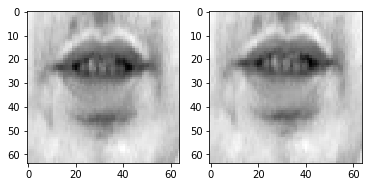

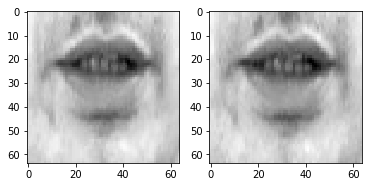

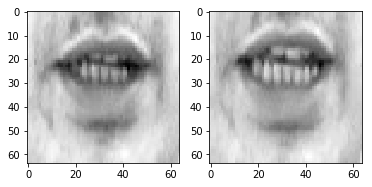

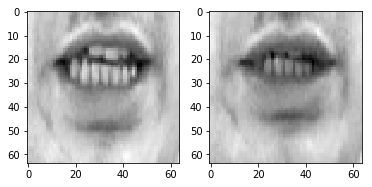

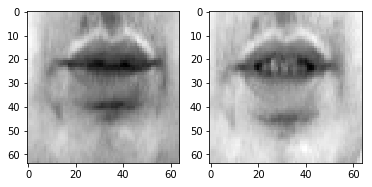

In [16]:

fig = plt.figure()


cnt = 0
random_frame = round((np.random.random())*2879)
# 1900


print(words[np.argmax(Y[random_frame])])

for i, frame in enumerate(X[random_frame]):
    if cnt%2 == 0:
        fig = plt.figure()
    frame = frame.reshape(64, 64)
    cnt+=1
    fig.add_subplot(1, 2, ((i)%2)+1)
    plt.imshow(frame, cmap='gray')


In [8]:
from keras.models import Sequential
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Conv3D
# https://github.com/tflearn/tflearn/issues/387

c:\users\chait\code\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:


def createModel(num_of_words):
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(10, 64, 64, 1), padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(10, kernel_size=(3, 3), padding='same'))
    seq.add(GlobalAveragePooling2D())
    seq.add(Dense(units = num_of_words, activation='softmax'))
    seq.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return seq


model = createModel(num_of_words)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 40)    59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 40)    115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 64, 64, 40)    115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 64, 64, 10)        18040     
__________

In [14]:
# history = model.fit(X, Y, batch_size = 1, epochs = 1,shuffle=True, verbose = 1, validation_split=0.5)

In [28]:
model.save('my_model.h5')

NameError: name 'model' is not defined

In [29]:
import generate_testdata
